In [99]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

matchups = {'2023': {}, '2022': {}}
print
for i in range(1, 14):
    matchups['2023'][i] = requests.get('https://api.sleeper.app/v1/league/989759581989462016/matchups/' + str(i)).json()
    matchups['2022'][i] = requests.get('https://api.sleeper.app/v1/league/865480395607646208/matchups/' + str(i)).json()

for year in ['2023', '2022']:
    for week in range(1, 14):
        for matchup in matchups[year][week]:
            matchup['roster_id'] = str(matchup['roster_id']) + '_' + year
players_txt = open('response.txt', 'r').read()
players = json.loads(players_txt)

In [94]:
test_leagues = {}
rng = np.random.default_rng()
league_id = str(int(rng.random() * 10**18))
test_leagues[league_id] = requests.get('https://api.sleeper.app/v1/league/' + league_id + '/matchups/' + str(i)).json()
print(test_leagues[league_id] == None)

True


In [91]:
print(test_leagues)

{'959828970127356928': None}


In [30]:
player_id_join = {}
for player in players:
    player_id_join[player] = players[player]['first_name'][0] + '.' + players[player]['last_name']

In [36]:
weekly_table = nfl.import_weekly_data([2023])
yearly_table = nfl.import_seasonal_data([2023])
weekly = pd.DataFrame(weekly_table)
yearly = pd.DataFrame(yearly_table)

weekly['half_ppr'] = (weekly['fantasy_points'] + weekly['fantasy_points_ppr']) / 2
yearly['half_ppr'] = (yearly['fantasy_points'] + yearly['fantasy_points_ppr']) / 2

qb_weekly = weekly[weekly['position_group'] == 'QB']
rb_weekly = weekly[weekly['position_group'] == 'RB']
wr_weekly = weekly[weekly['position_group'] == 'WR']
te_weekly = weekly[weekly['position_group'] == 'TE']
k_weekly = weekly[weekly['position'] == 'K']

Downcasting floats.


In [31]:
player_data = {}
for player in players:
    player_data[player] = {'position': players[player]['position'], 'name': player_id_join[player]}


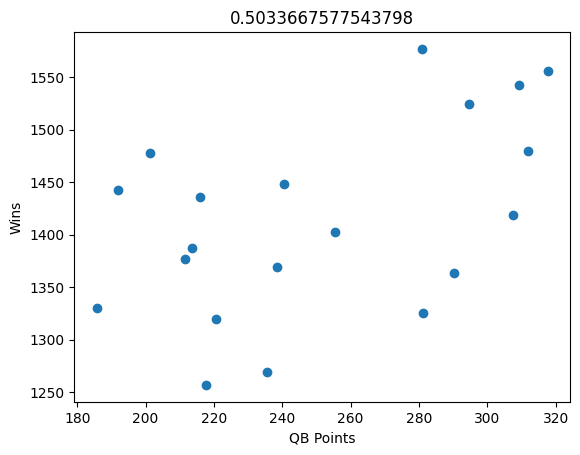

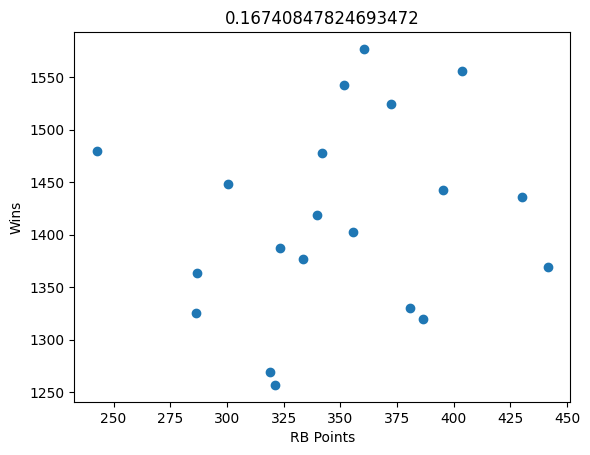

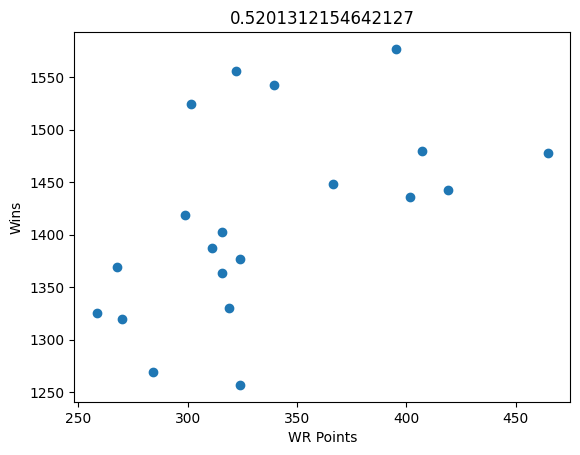

In [113]:
positions = ['QB', 'RB', 'RB', 'WR', 'WR', 'TE', 'FLX', 'K', 'DEF']
positions_numbered = ['QB', 'RB1', 'RB2', 'WR1', 'WR2', 'TE', 'FLX', 'K', 'DEF', 'W', 'L', 'total', 'team']
formatted_matchups = []
points_per_position = {'W': {}, 'L': {}}
all_scores = []

for i in positions:
    points_per_position['W'][i] = 0
    points_per_position['L'][i] = 0

all_score = []
idx = 0
for year in ['2023', '2022']:
    for week in range(1, 14):
        for matchup in matchups[year][week]:
            all_score = []
            match_id = matchup['matchup_id']
            same_matchup = [m for m in matchups[year][week] if (m['matchup_id'] == match_id and m['roster_id'] != matchup['roster_id'])]
            w_l = 1 if matchup['points'] > same_matchup[0]['points'] else 0

            for i, starter in enumerate(matchup['starters']):
                if (starter in player_data):
                    all_score.append(matchup['players_points'][starter])
                else:
                    all_score.append(0)
            all_score.append(w_l)
            all_score.append(1 if w_l == 0 else 0)
            all_score.append(matchup['points'])
            all_score.append(matchup['roster_id'])
            all_scores.append(all_score)
            idx += 1

all_scores_df = pd.DataFrame(all_scores, columns=positions_numbered)
winning_scores = all_scores_df[all_scores_df['W'] == 1]
losing_scores = all_scores_df[all_scores_df['L'] == 1]

team_scores = all_scores_df.groupby('team').sum()
team_scores['RB'] = team_scores['RB1'] + team_scores['RB2']
team_scores['WR'] = team_scores['WR1'] + team_scores['WR2']

plt.scatter(team_scores['QB'], team_scores['total'])
plt.xlabel('QB Points')
plt.ylabel('Wins')
plt.title(np.corrcoef(team_scores['QB'], team_scores['total'])[0,1])

plt.show()

plt.scatter(team_scores['RB'], team_scores['total'])
plt.xlabel('RB Points')
plt.ylabel('Wins')
plt.title(np.corrcoef(team_scores['RB'], team_scores['total'])[0,1])
plt.show()

plt.scatter(team_scores['WR'], team_scores['total'])
plt.xlabel('WR Points')
plt.ylabel('Wins')
plt.title(np.corrcoef(team_scores['WR'], team_scores['total'])[0,1])
plt.show()

In [66]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):   
    print(team_scores)

          QB     RB1    RB2     WR1    WR2      TE     FLX     K    DEF   W  \
team                                                                          
1      46.22   49.80   60.7   58.30   66.1   22.90   35.60  29.0   31.0   3   
2     105.14  128.20   53.9   71.80   68.9   96.00   91.70  62.0   48.0   6   
3     108.40   65.50   82.9   95.30   53.2   68.00   61.00  38.0   53.0   5   
4     202.32  118.70  103.3  119.92   83.7   92.00  115.60  71.0   91.0   8   
5     200.24  144.70  125.1  152.40  156.8  105.70  148.40  75.0  114.0  10   
6     121.64   76.50   72.8  131.00   62.5   55.00   78.00  43.0   75.0   6   
7     199.18   61.80  110.3  130.20  120.1   74.10  110.80  63.0   83.0   8   
8     216.70  117.28  104.4  157.20  144.5   95.20  186.66  65.0  102.0  10   
9     119.38   77.00  141.0   41.50   59.2   63.08   89.90  38.0   54.0   6   
10     69.86   46.30   34.8   57.20   27.3   29.30   38.00  23.0   35.0   3   

      L    total  
team              
1     0   399